In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import pickle
import csv
import implicit
import itertools
import copy
plt.style.use('ggplot')

In [31]:
df = pd.read_csv('book_ratings_implicit.csv')
df.head()

,user_id,title,isbn
0,212142,the house at pooh corner,440437954
1,138777,the house at pooh corner,440437954
2,144997,the house at pooh corner,440437954
3,76626,the house at pooh corner,440437954
4,171118,the house at pooh corner,440437954


In [32]:
df = df[['user_id', 'isbn']]
df.head()

,user_id,isbn
0,212142,440437954
1,138777,440437954
2,144997,440437954
3,76626,440437954
4,171118,440437954


In [33]:
n_users = df.user_id.unique().shape[0]
n_items = df.isbn.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of books: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(df.shape[0]) / float(n_users*n_items) * 100))

Number of users: 10717
Number of books: 4888
Sparsity: 0.174%


In [34]:
# Create mappings
isbn_to_idx = {}
idx_to_isbn = {}
for (idx, isbn) in enumerate(df.isbn.unique().tolist()):
    isbn_to_idx[isbn] = idx
    idx_to_isbn[idx] = isbn
    
user_id_to_idx = {}
idx_to_user_id = {}
for (idx, user_id) in enumerate(df.user_id.unique().tolist()):
    user_id_to_idx[user_id] = idx
    idx_to_user_id[idx] = user_id

In [35]:
def map_ids(row, mapper):
    return mapper[row]

In [36]:
# Create sparse matrix
I = df.user_id.apply(map_ids, args=[user_id_to_idx]).as_matrix()
J = df.isbn.apply(map_ids, args=[isbn_to_idx]).as_matrix()
V = np.ones(I.shape[0])
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

/Users/hhn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/hhn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
I = df.user_id.apply(map_ids, args=[user_id_to_idx]).as_matrix()
J = df.isbn.apply(map_ids, args=[isbn_to_idx]).as_matrix()
V = np.ones(I.shape[0])
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

/Users/hhn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/hhn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [38]:
# Split train/test
def train_test_split(ratings, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    
    Params
    ------
    ratings : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all 
        users are considered.
    """
    train = ratings.copy().tocoo()
    test = sparse.lil_matrix(train.shape)
    
    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0], 
                replace=False,
                size=np.int32(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*split_count, fraction))
            raise
    else:
        user_index = range(train.shape[0])
        
    train = train.tolil()

    for user in user_index:
        test_ratings = np.random.choice(ratings.getrow(user).indices, 
                                        size=split_count, 
                                        replace=True)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
   
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

In [39]:
train, test, user_index = train_test_split(likes, 5, fraction=0.2)

In [40]:
eval_train = train.copy()
non_eval_users = list(set(range(train.shape[0])) - set(user_index))

eval_train = eval_train.tolil()
for u in non_eval_users:
    eval_train[u, :] = 0.0
eval_train = eval_train.tocsr()

In [41]:
sideinfo = pd.read_csv('book_features_implicit.csv')
sideinfo.head()

,title,author,publication_year,isbn
0,the house at pooh corner,aamilne,1987,440437954
1,winnie the pooh,aamilne,1988,525444432
2,the frog king,adamdavies,2002,1573229385
3,paris to the moon,adamgopnik,2000,679444920
4,how to talk so kids will listen and listen so ...,adelefaber,1991,380570009


In [42]:
sideinfo=sideinfo[['isbn','author','publication_year']]
sideinfo.head()

,isbn,author,publication_year
0,440437954,aamilne,1987
1,525444432,aamilne,1988
2,1573229385,adamdavies,2002
3,679444920,adamgopnik,2000
4,380570009,adelefaber,1991


In [43]:
feat_dlist = [{} for _ in idx_to_isbn]
for idx, row in sideinfo.iterrows():
    feat_key = '{}_{}'.format(row.author,str(row.publication_year).lower())
    idx = isbn_to_idx.get(row.isbn)
    if idx is not None:
        feat_dlist[idx][feat_key] = 1

In [44]:
feat_dlist[0]

{'aamilne_1987': 1}

In [45]:
from sklearn.feature_extraction import DictVectorizer

In [46]:
dv = DictVectorizer()
item_features = dv.fit_transform(feat_dlist)

In [47]:
item_features

<4888x4087 sparse matrix of type '<class 'numpy.float64'>'
	with 4888 stored elements in Compressed Sparse Row format>

In [48]:
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif (isinstance(r, float)
              or isinstance(r, np.float32)
              or isinstance(r, np.float64)):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

def patk_learning_curve(model, train, test, eval_train,
                        iterarray, user_features=None,
                        item_features=None, k=5,
                        **fit_params):
    old_epoch = 0
    train_patk = []
    test_patk = []
    headers = ['Epoch', 'train p@5', 'test p@5']
    print_log(headers, header=True)
    for epoch in iterarray:
        more = epoch - old_epoch
        model.fit_partial(train, user_features=user_features,
                          item_features=item_features,
                          epochs=more, **fit_params)
        this_test = lightfm.evaluation.precision_at_k(model, test, train_interactions=None, k=k)
        this_train = lightfm.evaluation.precision_at_k(model, eval_train, train_interactions=None, k=k)

        train_patk.append(np.mean(this_train))
        test_patk.append(np.mean(this_test))
        row = [epoch, train_patk[-1], test_patk[-1]]
        print_log(row)
    return model, train_patk, test_patk

In [49]:
from lightfm import LightFM
import lightfm.evaluation
model = LightFM(loss='warp', random_state=2016)
# Initialize model.
model.fit(train, epochs=0);

iterarray = range(10, 110, 10)

model, train_patk, test_patk = patk_learning_curve(
    model, train, test, eval_train, iterarray, k=5, **{'num_threads': 4}
)

+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     10     |  0.14484   |  0.02371   |
+------------+------------+------------+
|     20     |  0.15100   |  0.02389   |
+------------+------------+------------+
|     30     |  0.14867   |  0.02240   |
+------------+------------+------------+
|     40     |  0.14494   |  0.02287   |
+------------+------------+------------+
|     50     |  0.14400   |  0.02165   |
+------------+------------+------------+
|     60     |  0.14176   |  0.02212   |
+------------+------------+------------+
|     70     |  0.14167   |  0.02231   |
+------------+------------+------------+
|     80     |  0.14204   |  0.02128   |
+------------+------------+------------+
|     90     |  0.14102   |  0.02091   |
+------------+------------+------------+
|    100     |  0.13999   |  0.02156   |
+------------+------------+------------+


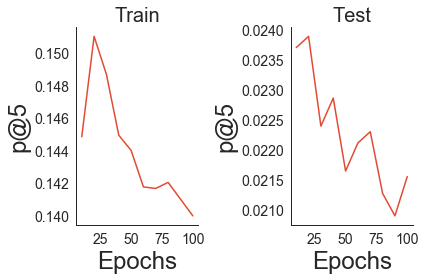

In [50]:
import seaborn as sns
sns.set_style('white')

def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('p@{}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout();

In [52]:
from skopt import forest_minimize

In [53]:
def objective(params):
    # unpack
    epochs, learning_rate,\
    no_components, alpha = params
    
    user_alpha = alpha
    item_alpha = alpha
    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
              num_threads=4, verbose=True)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                              train_interactions=None,
                                              k=5, num_threads=4)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

In [56]:
space = [(1, 10), # epochs
         (10**-4, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-6, 10**-1, 'log-uniform'), # alpha
        ]

res_fm = forest_minimize(objective, space, n_calls=250,
                     random_state=0,
                     verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.3753
Function value obtained: -0.0006
Current minimum: -0.0006
Iteration No: 2 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.9363
Function value obtained: -0.0156
Current minimum: -0.0156
Iteration No: 3 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.0199
Function value obtained: -0.0156
Current minimum: -0.0156
Iteration No: 4 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.2159
Function value obtained: -0.0161
Curre

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 3.8451
Function value obtained: -0.0273
Current minimum: -0.0300
Iteration No: 32 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 3.5632
Function value obtained: -0.0287
Current minimum: -0.0300
Iteration No: 33 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 3.9251
Function value obtained: -0.0156
Current minimum: -0.0300
Iteration No: 34 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 34 ended. Search finished for the next optimal 

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 3.1170
Function value obtained: -0.0132
Current minimum: -0.0301
Iteration No: 62 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 2.5911
Function value obtained: -0.0274
Current minimum: -0.0301
Iteration No: 63 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 2.1602
Function value obtained: -0.0242
Current minimum: -0.0301
Iteration No: 64 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 4.8425
Function value obtained: -0.0156
Current minimum: -0.0301
Iteration No: 65 sta

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 2.8032
Function value obtained: -0.0265
Current minimum: -0.0301
Iteration No: 93 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 4.1701
Function value obtained: -0.0227
Current minimum: -0.0301
Iteration No: 94 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 2.0010
Function value obtained: -0.0153
Current minimum: -0.0301
Iteration No: 95 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 4.1044
Function value obtaine

Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 7.9974
Function value obtained: -0.0283
Current minimum: -0.0301
Iteration No: 124 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 6.2962
Function value obtained: -0.0284
Current minimum: -0.0301
Iteration No: 125 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 7.0237
Function value obtained: -0.0018
Current minimum: -0.0301
Iteration No: 126 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 6.9451
Function value obtained: -0.0291
Curren

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 5.0502
Function value obtained: -0.0225
Current minimum: -0.0302
Iteration No: 153 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 4.9719
Function value obtained: -0.0290
Current minimum: -0.0302
Iteration No: 154 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 4.7632
Function value obtained: -0.0250
Current minimum: -0.0302
Iteration No: 155 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 6.7866
Function value 

Epoch 5
Epoch 6
Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 2.4104
Function value obtained: -0.0279
Current minimum: -0.0302
Iteration No: 183 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 2.4644
Function value obtained: -0.0143
Current minimum: -0.0302
Iteration No: 184 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 4.4346
Function value obtained: -0.0155
Current minimum: -0.0302
Iteration No: 185 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 4.7109
Function value obtained: -0.0229
Current minimum: -0.0302
Iteration No: 186 started. Searching 

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 3.3403
Function value obtained: -0.0302
Current minimum: -0.0302
Iteration No: 214 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 6.3318
Function value obtained: -0.0143
Current minimum: -0.0302
Iteration No: 215 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 215 ended. Search finished for the next optimal point.
Time taken: 6.6644
Function value obtained: -0.0194
Current minimum: -0.0302
Iteration No: 216 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Iteration No: 216 ended. Search finished for the next optimal p

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 5.8436
Function value obtained: -0.0258
Current minimum: -0.0327
Iteration No: 244 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 4.9807
Function value obtained: -0.0108
Current minimum: -0.0327
Iteration No: 245 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 4.9015
Function value obtained: -0.0300
Current minimum: -0.0327
Iteration No: 246 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 1.4790
Function value obtained: -0.0168
Current minimu

In [57]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'alpha']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.03266
Optimal parameters:
epochs: 9
learning_rate: 0.03589864099533542
no_components: 194
alpha: 0.00029244057400746806


In [59]:
from scipy import sparse as sp
eye = sp.eye(item_features.shape[0], item_features.shape[0]).tocsr()
item_features_concat = sp.hstack((eye, item_features))
item_features_concat = item_features_concat.tocsr().astype(np.float32)

In [60]:
def objective_wsideinfo(params):
    # unpack
    epochs, learning_rate,\
    no_components, item_alpha,\
    scale = params
    
    user_alpha = item_alpha * scale
    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
              item_features=item_features_concat,
              num_threads=4, verbose=True)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                              item_features=item_features_concat,
                                              train_interactions=None,
                                              k=5, num_threads=3)
    mapatk = np.mean(patks)
    out = -mapatk
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

In [61]:
space = [(1, 10), # epochs
         (10**-3, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-5, 10**-3, 'log-uniform'), # item_alpha
         (0.001, 1., 'log-uniform') # user_scaling
        ]
x0 = res_fm.x.append(1.)
# This typecast is required
item_features = item_features.astype(np.float32)
res_fm_itemfeat = forest_minimize(objective_wsideinfo, space, n_calls=50,
                                  x0=x0,
                                  random_state=0,
                                  verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.9942
Function value obtained: -0.0003
Current minimum: -0.0003
Iteration No: 2 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.5923
Function value obtained: -0.0230
Current minimum: -0.0230
Iteration No: 3 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.1274
Function value obtained: -0.0219
Current minimum: -0.0230
Iteration No: 4 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.1823
Function value obtained: -0.0130
Current minimum: -0.0

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 4.0385
Function value obtained: -0.0033
Current minimum: -0.0350
Iteration No: 34 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 4.8582
Function value obtained: -0.0211
Current minimum: -0.0350
Iteration No: 35 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 8.9000
Function value obtained: -0.0359
Current minimum: -0.0359
Iteration No: 36 started. Searching for the next optimal point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.3100
Functi

In [62]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm_itemfeat.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'item_alpha', 'scaling']
for (p, x_) in zip(params, res_fm_itemfeat.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.03593
Optimal parameters:
epochs: 10
learning_rate: 0.023335810763701524
no_components: 182
item_alpha: 0.00047540242427134206
scaling: 0.0011719802747360935
